# Setup

In [0]:
# First we authenticate
from google.colab import auth
auth.authenticate_user()

In [2]:
# Check tensorflow version (which seems to be 1.8.0)
import tensorflow as tf; print(tf.__version__)  # for Python 3

1.9.0


In [3]:
!mkdir data
!mkdir model
!mkdir log
!gsutil cp gs://ni-project-tu-mlengine/train.zip data
!gsutil cp gs://ni-project-tu-mlengine/test.zip data
!gsutil cp gs://ni-project-tu-mlengine/train.csv data
!gsutil cp gs://ni-project-tu-mlengine/bounding_boxes.csv data
!cd data && unzip -o -q train.zip && unzip -o -q test.zip && cd ..
# !mkdir data/train_preprocessed

Copying gs://ni-project-tu-mlengine/train.zip...
| [1 files][259.8 MiB/259.8 MiB]                                                
Operation completed over 1 objects/259.8 MiB.                                    
Copying gs://ni-project-tu-mlengine/test.zip...
/ [1 files][405.3 MiB/405.3 MiB]                                                
Operation completed over 1 objects/405.3 MiB.                                    
Copying gs://ni-project-tu-mlengine/train.csv...

Operation completed over 1 objects/221.3 KiB.                                    
Copying gs://ni-project-tu-mlengine/bounding_boxes.csv...
/ [1 files][685.6 KiB/685.6 KiB]                                                
Operation completed over 1 objects/685.6 KiB.                                    


In [14]:
!pip install tqdm
!pip install sklearn
!pip install opencv-python

    100% |████████████████████████████████| 51kB 2.0MB/s 
  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


# Configuration

In [0]:
"""
Configuration constants
"""

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Parameters from first iteration of random parameter search
config = Namespace(
    data_dir='data',
    job_dir='model',
    log_dir='log',
    image_target_size=(300,205),
)

# Preprocessing, Augmentation, Image Loading Pipeline

In [0]:
import cv2

def crop_label(img, stride=5, box_thresh=250, binary_thresh=200, erosion_kernel_size=7, iter_=8, median_kernel_size=7):
    """
    crop image notations. Since most of the text is written on an even background (like text on a white
    box), text will get removed by applying erosion and median filer. The resulting text box without the text will
    be removed, if the mean of pixel values is above box_threshold.

    :param (n x m array) img: grayscale image in format of a np.array with n rows and m columns.
    :param (int) stride: stride for box detection
    :param (int) box_thresh: threshold for empty textbox
    :param (int) binary_thresh: binary threshold for accentuating text boxes
    :param (int) erosion_kernel_size: size of erosion kernel
    :param (int) iter_: number of iterations of erosion operator
    :param (int) median_kernel_size: size of median filter kernel
    :return:
    """
    # accentuate text boxes
    img_thresh = ((img > binary_thresh)*255).astype('uint8')

    # remove text
    a = cv2.medianBlur(cv2.dilate(img_thresh, (erosion_kernel_size, erosion_kernel_size), iterations=iter_),
                       median_kernel_size)
    b = img

    # detect and remove plain boxes in bottom part of image
    for i in range(a.shape[0]//2, a.shape[0], stride):
        if a[i:].mean() > box_thresh:
            a = a[:i]
            b = b[:i]
            break

    # # detect and remove plain boxes in upper part of image
    # for i in range(a.shape[0]//2, 0, -stride):
    #     if a[:i].mean() > box_thresh:
    #         b = b[i:]
    #         break

    return b

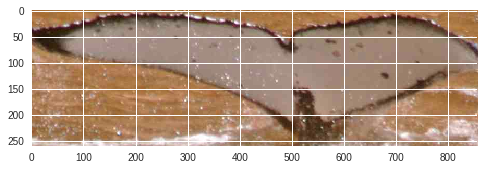

In [36]:
# df = pd.read_csv(join(config.data_dir,'bounding_boxes.csv'),)
path = '00f22419.jpg'
img = cv2.imread('data/train/'+path)
img = crop_fluke(path,img,df)
plt.imshow(img)

In [0]:
from tqdm import  tqdm
from threading import Thread
from queue import Queue
from os.path import join
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def crop_fluke(img_path,img,bbdf):
  box = bbdf[img_path].values.reshape(2,2)
  y_start = np.max([np.min(box[:,1]),0])
  y_end = np.min([np.max(box[:,1]),img.shape[0]-1])
  x_start = np.max([np.min(box[:,0]),0])
  x_end = np.min([np.max(box[:,0]),img.shape[1]-1])
  return img[y_start:y_end,x_start:x_end]
  
!rm -rf data/train_preprocessed
!mkdir data/train_preprocessed
def preprocess_images(src_dir,dst_dir,bounding_boxes_csv,target_size,workers=10):
    df = pd.read_csv(bounding_boxes_csv)
    q = Queue()
    
    for img_path in os.listdir(src_dir):
        if img_path.endswith('.jpg'):
            q.put(img_path)
        
    pbar = tqdm(total=q.qsize())
    def worker():
        while not q.empty():
            img_path = q.get()
            orig_img = cv2.imread(join(src_dir,img_path),cv2.IMREAD_GRAYSCALE)
            img = crop_fluke(img_path,orig_img,df)
            img = cv2.resize(img,target_size)
            cv2.imwrite(join(dst_dir,img_path),img)
            q.task_done()
            pbar.update(1)
    
    for i in range(workers):
        Thread(target=worker).start()
    
    q.join()
    pbar.close()

preprocess_images(
  join(config.data_dir,'train'),
  join(config.data_dir,'train_preprocessed'),
  join(config.data_dir,'bounding_boxes.csv'),
  config.image_target_size
)

In [40]:
from keras.preprocessing.image import random_rotation, random_zoom

def random_transformations(image,n):
    augmentations = []
    mean = image.mean()
    for i in range(n):
        img = random_rotation(image, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant',cval=mean)
        img = random_zoom(img, zoom_range=(0.9, 1.5), row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant',cval=mean)
        augmentations.append(img)

    return augmentations

Using TensorFlow backend.


In [0]:
"""
Generators to load images for training, validation and test
"""
import os
from keras.utils import Sequence
import pandas
import tensorflow as tf
from keras.preprocessing.image import img_to_array, load_img
import keras.backend as K
import numpy as np
import cv2
identity = lambda x: x
from os.path import join


def encode_label(label):
    if label == 'new_whale':
        return 0
    else:
        return int(label[2:], 16)

def normalize(img):
    return (img - img.mean(axis=(0,1)))/img.std(axis=(0,1))

class ImageLoader(Sequence):

    def __init__(
        self,
        path, 
        batch_size,
        target_size,
        labels_csv=None, 
        labels_df=None,
        shuffle=False,
        preprocess=None,
        preprocess_post_aug=None,
        augment=False,
        n_augmentations=3,
        normalize=True,
        return_labels=False,
        eliminate_new_whale=True
    ):
        if labels_csv is not None or labels_df is not None:
          if labels_csv:
            data = pandas.read_csv(labels_csv, converters={'Id': encode_label})
          else:
            data = labels_df
          # eliminate new_whale
          if eliminate_new_whale:
            data = data[data['Id']!=0]
          self.labels = data['Id'].values
          self.img_paths = data['Image'].values
        else:
          self.img_paths = np.array([path for path in os.listdir(path) if path.endswith('.jpg')])
          self.labels = None
        
        self.batch_size = batch_size
        self.path = path
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.preprocess_post_aug = preprocess_post_aug
        self.target_size = target_size
        self.augment = augment
        self.n_augmentations = n_augmentations
        self.normalize = normalize
        self.return_labels = return_labels
        self.on_epoch_end()
        
    def load_img(self,img_path):
        img = cv2.imread(join(self.path,img_path),cv2.IMREAD_GRAYSCALE)
        if self.preprocess is not None:
          img = self.preprocess(img)
        img = cv2.resize(img,self.target_size)
        return np.repeat(img[:,:,np.newaxis],3,axis=2)

    def __getitem__(self, idx):
        idx_start = np.max([0, int(self.batch_size * idx)])
        idx_end = np.min([idx_start + self.batch_size, len(self.img_paths)])
        img_path_batch = self.img_paths[self.permutation[idx_start:idx_end]]
        imgs = list(map(self.load_img,img_path_batch))
        labels_batch = None
        if self.labels is not None and self.return_labels:
          labels_batch = self.labels[self.permutation[idx_start:idx_end]]
#         if self.augment:
#           imgs = imgs + [np.fliplr(img) for img in imgs]
#           if self.labels is not None and self.return_labels:
#             labels_batch = np.repeat(labels_batch,2)
        if self.augment:
          imgs_aug = []
          for img in imgs:
            imgs_aug = imgs_aug + random_transformations(img, self.n_augmentations)
          imgs = imgs + imgs_aug
          if self.labels is not None and self.return_labels:
            labels_batch = np.repeat(labels_batch,self.n_augmentations + 1)
            img_path_batch = np.repeat(img_path_batch,self.n_augmentations + 1)
        if self.preprocess_post_aug is not None:
          for i in range(len(imgs)):
            imgs[i] = self.preprocess_post_aug(imgs[i].astype('float64'))
        if self.normalize:
          for i in range(len(imgs)):
            imgs[i] = normalize(imgs[i])
        imgs = np.array(imgs)
        if self.labels is not None and self.return_labels:
          return imgs,labels_batch
        return imgs

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.permutation = np.random.permutation(len(self.img_paths))
        else:
            self.permutation = np.arange(len(self.img_paths))          

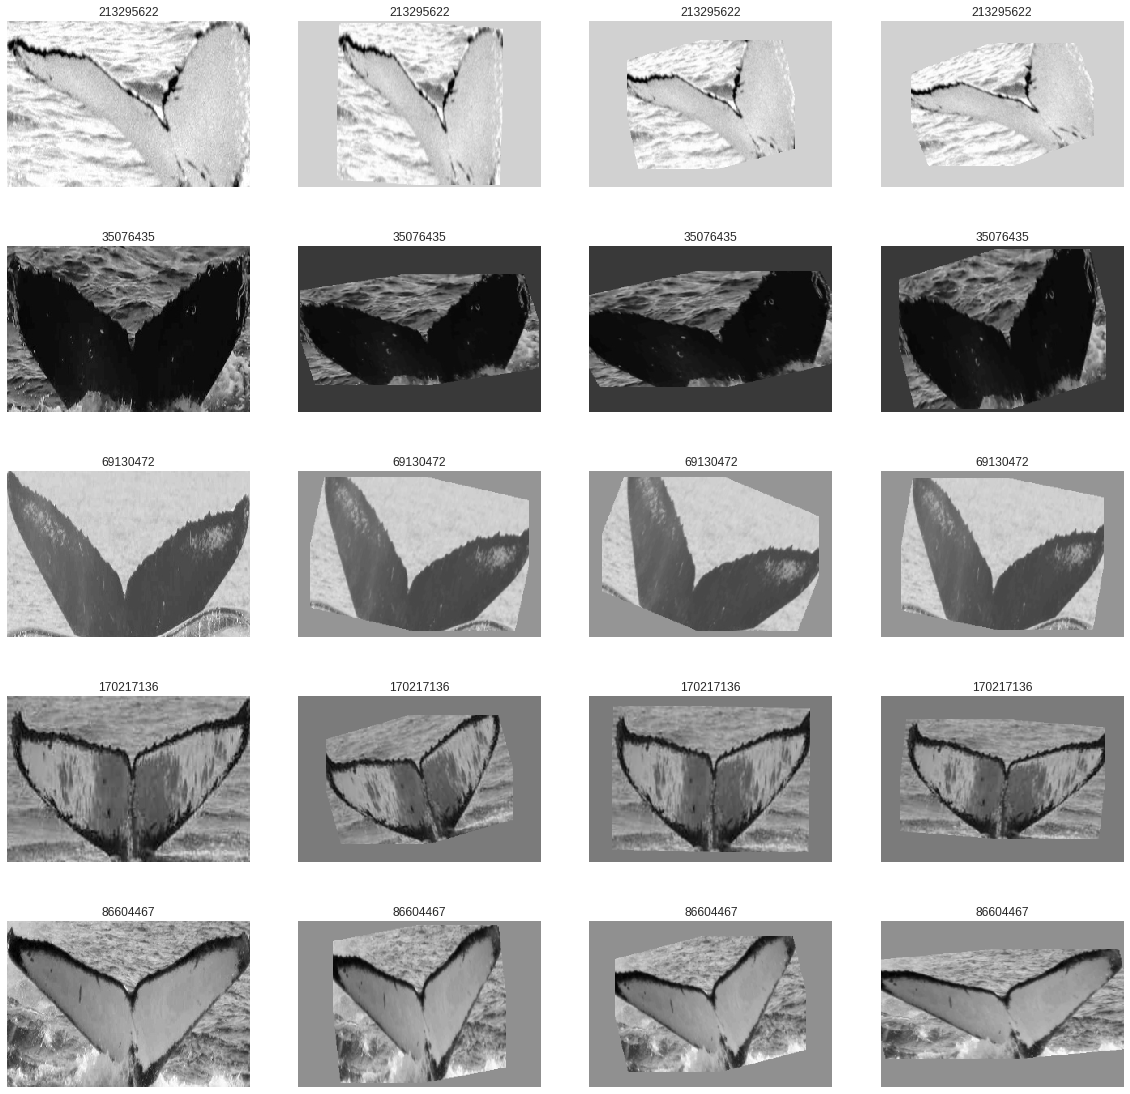

In [46]:
# Just to make sure the image loader doesnt output nonsense
import matplotlib.pyplot as plt
import cv2
from keras.applications.inception_v3 import InceptionV3, preprocess_input

img_loader = ImageLoader(
    labels_csv=join(config.data_dir, "train.csv"),
    path=join(config.data_dir, "train_preprocessed"),
    batch_size=1,
    shuffle=True,
    target_size=config.image_target_size,
#     preprocess_post_aug=preprocess_input,
    augment=True,
    normalize=False,
    return_labels=True,
)

fig, ax = plt.subplots(5,4)
fig.set_figheight(20)
fig.set_figwidth(20)

for i in range(5):
    batch, labels = img_loader[i]
    for j,img in enumerate(batch):
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
        ax[i,j].set_title(labels[j])
        ax[i,j].imshow(img)

# Precomputation

In [0]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import h5py

def precompute_inception_output(src_folder,outfile,labels_csv=None):
  naug = 10
  has_labels = labels_csv != None
  img_loader = ImageLoader(
    labels_csv=labels_csv,
    path=src_folder,
    batch_size=1,
    preprocess_post_aug=preprocess_input,
    target_size=config.image_target_size,
    augment=has_labels,
    n_augmentations=naug,
    return_labels= has_labels,
    eliminate_new_whale=False,
    shuffle=False,
    normalize=False
  )
  inception = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
  X = inception.predict_generator(img_loader, verbose=1)
  with h5py.File(outfile, 'w') as f:
    X_dset = f.create_dataset('X', data=X)
    if has_labels:
      img_paths = np.repeat(img_loader.img_paths,naug+1).astype('object')
    else:
      img_paths = img_loader.img_paths.astype('object')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('img_paths', data=img_paths,  dtype=string_dt)
    if has_labels:
      y = np.repeat(img_loader.labels,naug+1)
      y_dset = f.create_dataset('y', data=y)


In [48]:
!rm data/train_precomputed.h5
precompute_inception_output(  
    join(config.data_dir, 'train_preprocessed'),
    'data/train_precomputed.h5',
    labels_csv=join(config.data_dir, 'train.csv'),
)

rm: cannot remove 'data/train_precomputed.h5': No such file or directory
 253/9850 [..............................] - ETA: 49:29

9850/9850 [==============================] - 2972s 302ms/step


In [0]:
!mkdir data/test_preprocessed
preprocess_images(
  join(config.data_dir,'test'),
  join(config.data_dir,'test_preprocessed'),
  join(config.data_dir,'bounding_boxes.csv'),
  config.image_target_size
)

In [52]:
!rm data/test_precomputed.h5
precompute_inception_output(
    join(config.data_dir, 'test_preprocessed'),
    'data/test_precomputed.h5'
)

rm: cannot remove 'data/test_precomputed.h5': No such file or directory
 1487/15610 [=>............................] - ETA: 10:42

15610/15610 [==============================] - 688s 44ms/step


In [35]:
# !gsutil cp data/test_precomputed.h5 gs://ni-project-tu-mlengine/
# !gsutil cp data/train_precomputed.h5 gs://ni-project-tu-mlengine/
!mkdir data
!gsutil cp gs://ni-project-tu-mlengine/test_precomputed.h5 data/
!gsutil cp gs://ni-project-tu-mlengine/train_precomputed.h5 data/

Copying gs://ni-project-tu-mlengine/test_precomputed.h5...
| [1 files][129.8 MiB/129.8 MiB]                                                
Operation completed over 1 objects/129.8 MiB.                                    
Copying gs://ni-project-tu-mlengine/train_precomputed.h5...
- [1 files][852.4 MiB/852.4 MiB]   70.8 MiB/s                                   
Operation completed over 1 objects/852.4 MiB.                                    


In [37]:
!ls data

test_precomputed.h5  train_precomputed.h5


# Model Definition

## Triplet-Loss

In [0]:
"""
Definition of triplet loss
"""

def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]

    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.

    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]

    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=True):
    """Build the triplet loss over a batch of embeddings.

    We generate all the valid triplets and average the loss over the positive ones.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=True):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss


def make_triplet_loss(margin, squared=True):
    return lambda labels, embeddings: batch_hard_triplet_loss(labels, embeddings, margin, squared)

In [0]:
def make_semihard_triplet_loss(margin):
    loss = tf.contrib.losses.metric_learning.triplet_semihard_loss
    return lambda labels, embeddings: loss(tf.reshape(labels, shape=[-1]), embeddings, margin)

# Model Definition

In [0]:
from sklearn.neighbors import NearestNeighbors

      
def knn_predictor(X_train, y_train, X_test, k=5, n_neighbors=10, n_jobs=1):
    assert X_train.shape[1] == X_test.shape[1]
    assert y_train.shape[0] == X_train.shape[0]
    # The embeddings appear to be quite sparse, 
    # so we might as well remove the useless dimensions
    useful_dims = (X_train.std(axis=0) != 0)
    Xt = X_train[:,useful_dims]
    X = X_test[:,useful_dims]
    classifier = NearestNeighbors(n_neighbors=n_neighbors,n_jobs=n_jobs)
    classifier.fit(Xt)

    dist, y_ind = classifier.kneighbors(X, return_distance=True)
    # Find the indices of the first occurences of k unique neighbours
    sort_unique = lambda x: np.sort(np.unique(x, return_index=True)[1])
    unique_ind = np.array(list(map(sort_unique,y_ind)))
    y_pred =  np.array([y_train[z[x]] for x, z in zip(unique_ind, y_ind)])[:,:k]
#     new_thresh = 2e-7
#     dists_pred = np.array([z[x] for x, z in zip(unique_ind, dist)])[:,:k]
#     new_idx = dists_pred[:,0] > new_thresh
#     new_whales = np.zeros((new_idx.sum(),1))
#     y_pred[new_idx] = np.hstack([new_whales,y_pred[new_idx][:,:k-1]])
#     return y_pred
    return y_pred, y_ind, dist

# from sklearn.neighbors import KNeighborsClassifier

# def knn_predictor(X_train, y_train, X_test, k=1, n_neighbors=1, n_jobs=1):
#     assert X_train.shape[1] == X_test.shape[1]
#     assert y_train.shape[0] == X_train.shape[0]
#     classifier = KNeighborsClassifier(n_neighbors=1)
#     classifier.fit(X_train,y_train)
#     return classifier.predict(X_test)[:,np.newaxis]


In [0]:
def get_triplets(y):
  pos_ex = y[np.newaxis] == y[:,np.newaxis]
  neg_ex = np.logical_not(pos_ex)
  np.fill_diagonal(pos_ex,False)
  triplets_mask = np.logical_and(pos_ex[:,:,np.newaxis],neg_ex[np.newaxis])
  triplets = np.array(np.nonzero(triplets_mask)).T
  return triplets

In [0]:
from sklearn.base import BaseEstimator
from keras.optimizers import Adam
from keras.utils import Sequence

def mapk(y_pred,y_true):
    assert y_pred.ndim == 2 and y_true.ndim == 1 and y_pred.shape[0] == y_true.shape[0]
    return np.max((y_pred == y_true[:,np.newaxis])/np.arange(1,y_pred.shape[1]+1),axis=1).mean()
  
class BatchSequence(Sequence):

  def __init__(self, X, y=None, batch_size=100, include_idx=None, shuffle=False):
      self.X = X
      self.y = y
      self.batch_size = batch_size
      self.shuffle = shuffle
      # Filter the elements that are excluded
      # We need to do it this way because we dont want to load the whole
      # dataset at once, but instead utilize the hdf5 format
      self.ord = np.arange(len(X))
      if include_idx is not None:
        self.ord = self.ord[include_idx]
      self.on_epoch_end()
       

  def __len__(self):
      return int(np.ceil(len(self.ord) / float(self.batch_size)))

  def __getitem__(self, idx):
    start_idx = idx * self.batch_size
    end_idx = np.min([start_idx + self.batch_size,len(self.ord)])
    batch_idx = list(np.sort(self.ord[start_idx:end_idx]))
    if self.y is None:
      return self.X[batch_idx]
    return self.X[batch_idx], self.y[batch_idx]
  
  def on_epoch_end(self):
    if self.shuffle:
        np.random.shuffle(self.ord)
        
        

class SiameseNetworkEstimator(BaseEstimator):
  
    def __init__(self, learning_rate=None, triplet_loss_margin=None, dropout=None, regularization=None, layer_dims=None):
        self.learning_rate = learning_rate
        self.triplet_loss_margin = triplet_loss_margin
        self.dropout = dropout
        self.regularization = regularization
        self.layer_dims = layer_dims
        
    def load_model(sself,weight_file, X, y, train_idx):
        self.init_convnet()
        self.convnet.load_weights(path)
        self._calc_train_embeddings(X, y, train_idx)
        
    def _init_convnet(self):
        self.convnet = conv_net(
            dropout=self.dropout,
            regularization=self.regularization,
            layer_dims=self.layer_dims
        )
        opt = Adam(self.learning_rate)
        self.convnet.compile(loss=make_triplet_loss(self.triplet_loss_margin), optimizer=opt)
      

    def fit(self, X, y, train_idx, batch_size=700, **fitargs):
        self._init_convnet()
        train_gen = BatchSequence(X,y,batch_size, train_idx,shuffle=True)
        # Exclude augmentations...
        aug_stride = 11
        train_idx_no_aug = train_idx[::aug_stride]
        self.labels_train = np.array(y[train_idx_no_aug])
        
        self.convnet.fit_generator(train_gen,**fitargs)
        self._calc_train_embeddings(X, y, train_idx_no_aug)


    def predict(self, X, y=None, verbose=0, n_jobs=-1):
        test_gen = BatchSequence(X,y,batch_size=100)
        embeddings = self.convnet.predict_generator(test_gen,verbose=verbose)
        y_pred, y_ind, dists = knn_predictor(self.embeddings_train, self.labels_train, embeddings, n_jobs=n_jobs)
        return y_pred, y_ind, dists
      
      
    def _calc_train_embeddings(self, X, y, train_idx):
        train_embedd_gen = BatchSequence(X,include_idx=train_idx)
        self.embeddings_train = self.convnet.predict_generator(train_embedd_gen)
      

    def score(self, X_val, y_val, return_pred=False):
        y_pred, y_ind, dists = self.predict(X_val)
        score = mapk(y_pred, y_val)
        if not return_pred:
          return score
        return score, y_pred, y_val, y_ind, dists
        

## Conv-Net

In [19]:
"""
Definition of Model
"""

from keras.layers import Lambda, Dense, Dropout, GlobalMaxPooling2D, Input, MaxPooling1D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.applications.resnet50 import ResNet50

def conv_net(dropout=0.5, regularization=1e-1, layer_dims=[256]):
    """
    :param (tuple) input_shape:
    :param margin:
    :return:
    """
    input = Input(shape=(2048,))
    x = Dropout(dropout)(input)
    for dim in layer_dims[:-1]:
      x = Dense(dim,activation='relu',kernel_regularizer=l2(regularization))(x)
    x = Dense(layer_dims[-1],activation='tanh',kernel_regularizer=l2(regularization))(x)
#     normalized = Lambda(lambda x: K.l2_normalize(x, axis=1))(x)
    normalized=x
    
    return Model(input, normalized, name="clemens peters")
  
conv_net().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


In [0]:
import numpy as np

def test_mapk():
  y_true = np.array([1,2,3,4])
  y_pred = np.array([
      [1,0,0],
      [0,2,0],
      [0,0,3],
      [0,0,0]
  ])
  expected = (1 + 1/2 + 1/3 + 0) / 4
  assert(mapk(y_pred,y_true) == expected)
  assert(mapk(y_true[:,np.newaxis],y_true) == 1)
test_mapk()

# Parameter Optimization

In [0]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from itertools import product


params = dict(
    learning_rate = np.logspace(-3,-1,20),
    triplet_loss_margin = [0.2],
    dropout = np.linspace(0.05,0.95,20),
    regularization=np.logspace(-1,-3,20)
)

kfold = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
estimator = SiameseNetworkEstimator()
grid_search = RandomizedSearchCV(estimator, params, cv=kfold, verbose=10,error_score='raise',n_iter=1)


In [134]:
# overlord params
# triplet_loss_margin=0.8590909090909091, learning_rate=0.0038464646464646465, layers_activated=17, embedd_size=256, dropout=0.5421052631578946, score=0.6109835355285962, total= 1.3min

with h5py.File('data/train_precomputed_aug.h5', 'r') as f:
  X_train = np.array(f['X'])
  y_train = np.array(f['y'])
  print(X_train.shape)
#   not_new_whale = y_train != 0
#   X_train = X_train[not_new_whale]
#   y_train = y_train[not_new_whale]
#   grid_search.fit(X_train,y_train,epochs=8,batch_size=600,verbose=1)

(108350, 2048)


In [527]:
df = pd.DataFrame(grid_search.cv_results_)
cols = [col for col in df.columns if col.startswith('param_')] + ['mean_test_score','std_test_score']
df[cols]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

,param_dropout,param_layer_dims,param_learning_rate,param_regularization,param_triplet_loss_margin,mean_test_score,std_test_score
0,0.618421,[256],0.00162378,0.00695193,0.000263027,0.514657,0.020812
1,0.0973684,[256],0.0183298,0.0297635,0.000263027,0.441349,0.010192
2,0.381579,[256],0.0233572,0.00335982,0.000691831,0.467584,0.003559
3,0.192105,[256],0.001,0.0112884,0.000263027,0.510311,0.009481
4,0.760526,[256],0.00335982,0.00885867,0.0537032,0.592796,0.016175
5,0.476316,[256],0.00695193,0.0379269,0.60256,0.625388,0.002747
6,0.571053,[256],0.0233572,0.0143845,0.00776247,0.576828,0.007319
7,0.902632,[256],0.0379269,0.00428133,0.371535,0.244130,0.098126
8,0.618421,[256],0.0183298,0.0183298,0.00776247,0.600240,0.010706
9,0.05,[256],0.0183298,0.0143845,0.0331131,0.489793,0.014345


In [0]:
#  hyperparams = Namespace(  
#     triplet_loss_margin=0.000001,
#      learning_rate=0.0038464646464646465,
#      layer_dims=[256],
#      dropout=0.5421052631578946
#  )



# Training

In [0]:
hyperparams = {
  'triplet_loss_margin': 0.1,
  'learning_rate': 0.0005,
  'dropout': 0.8,
  'regularization': 0.07,
  'layer_dims': [512]
}

In [0]:
def split_val_train_idx(Y_dset, dup_indices, new_whale_ratio=0.325):
  dups = set(dup_indices)
  Y_aug = np.array(Y_dset)
  Y = Y_aug[::11]
  s = pd.Series(Y)
  counts = dict(s.value_counts())
  classes = set(counts.keys())
  val_counts = dict(counts)
  val_idx = []
  train_idx = []
  # We throw away pictures that are alone in their class
  # We want one image of each class in out validation set
  # All others go to the training set
  for i,y in enumerate(Y):
    # skip duplicates
    if (i * 11) in dups:
      continue
    #skip new whales and every whale that has just one image
    if y == 0 or counts[y] < 2:
      continue
    if val_counts[y] == counts[y]:
      val_idx.append(i)
      val_counts[y] = val_counts[y] - 1
    else:
      train_idx.append(i)
  # Now we add new whales in a proportion similar to the actual test set
  new_whales = np.arange(len(Y))[Y == 0]
  np.random.shuffle(new_whales)
  n_new_whales = int(new_whale_ratio/(1-new_whale_ratio) * len(val_idx))
  new_whales = new_whales[:n_new_whales]
  val_idx = np.sort(np.append(val_idx,new_whales))
  # convert Y (unaugmented) indices to Y_aug (augmented) indices
  train_idx = np.array(train_idx) * 11
  val_idx = np.array(val_idx) * 11
  # Add in some augmentations to the training set
  # We know that in y_aug, every subsequent 11 images are augmentations of the first one in the sequence
  # TODO: Maybe we have to just augment classes that arent overrepresented?
  n_aug = 3
  train_len = len(train_idx)
  train_idx = np.repeat(train_idx, n_aug + 1)
  train_idx = train_idx + np.repeat(np.arange(n_aug + 1)[np.newaxis], train_len, axis=0).flatten()
  return list(train_idx), list(val_idx)

In [0]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import cv2
from os.path import join
from tqdm import tqdm

def insert_new_whale(y_pred, dists, threshold):
  yp = np.copy(y_pred)
  for i in range(len(yp)):
    for j in range(len(yp[i])):
      if dists[i,j] > threshold:
        yp[i] = np.insert(yp[i],j,0)[:-1]
        break
  return yp

def optimize_new_whale_threshold(y_pred,y_true,dists):
  threshs = np.append(0,np.unique(dists))
  cur_score = 0
  best_score = -np.inf
  best_pred = None
  best_thresh = 0
  for t in threshs:
    yp = insert_new_whale(y_pred, dists, t)
    cur_score = mapk(yp, y_true)
    if cur_score <= best_score:
      break
    else:
      best_score = cur_score
      best_pred = yp
      best_thresh = t
  return best_score, best_pred, best_thresh

class ValidationCallback(Callback):
  
    def __init__(self,X,Y,train_idx,val_idx,estimator,
                 early_stopping=True,early_stopping_thresh=0.001):
      self.X_val = np.array(X[list(val_idx)])
      self.Y_val = np.array(Y[list(val_idx)])
      self.estimator = estimator
      self.val_idx = val_idx
      self.train_idx = train_idx
      self.early_stopping = early_stopping
      self.early_stopping_thresh = early_stopping_thresh
      self.max_score = 0
      self.X_dset = X
      self.Y_dset = Y
      
    def on_train_begin(self,bla,logs={}):
#       self.on_epoch_end(0)
      pass

    def on_epoch_end(self, epoch, logs={}):
      self.estimator._calc_train_embeddings(self.X_dset,self.Y_dset,list(self.train_idx[::11]))
      score, y_pred, y_val, y_ind, dists = self.estimator.score(self.X_val,self.Y_val, return_pred=True)
      score, y_pred, thresh = optimize_new_whale_threshold(y_pred,y_val,dists)
#       correct_idx = (y_pred == y_val[:,np.newaxis])[:,1]
#       idx = np.array(self.val_idx)[correct_idx][10:20]
#       nn_idx = np.array(self.train_idx)[y_ind[:,0]][correct_idx][10:20]
#       fig, ax = plt.subplots(len(idx),2)
#       fig.set_figheight(50)
#       fig.set_figwidth(20)
     
      
#       for i,tup in enumerate(zip(nn_idx,idx)):
#           nn,p = tup
#           nn_img = cv2.imread(join(config.data_dir,'train',img_paths[nn]))
#           p_img = cv2.imread(join(config.data_dir,'train',img_paths[p]))
#           ax[i,0].axes.get_xaxis().set_visible(False)
#           ax[i,0].axes.get_yaxis().set_visible(False)
#           ax[i,1].axes.get_xaxis().set_visible(False)
#           ax[i,1].axes.get_yaxis().set_visible(False)
#           ax[i,0].imshow(p_img)
#           ax[i,1].imshow(nn_img)
#       plt.show()
      if self.early_stopping:
        if score < (self.max_score - self.early_stopping_thresh):
          self.model.stop_training = True
          print('Early stopping. Restoring optimal weights.')
          self.model.load_weights('tmp_best_weights.h5')
        elif score > self.max_score:
          self.model.save_weights('tmp_best_weights.h5')
          self.max_score = score
      print(f'Valdidation MAPK: {score}, New-Whale-Threshold: {thresh}')
      

In [0]:
from os.path import join, isdir
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
# from keras.optimizers import Adam
import tensorflow as tf
import datetime
import pandas as pd
import h5py
import numpy as np

def train_val_model(config, hyperparams):

    with h5py.File('data/train_precomputed.h5', 'r') as f:
      # Get a validation split
      X_dset = f['X']
      y_dset = f['y']
      duplicates = f['duplicate_indices']
      not_new = np.arange(len(y_dset))[np.array(y_dset) != 0]
      train_idx, val_idx = split_val_train_idx(y_dset,duplicates)
      print(len(train_idx))
      print(len(val_idx))
      model = SiameseNetworkEstimator(**hyperparams)

      callbacks = [
#           TensorBoard(log_dir=config.log_dir),
#           ModelCheckpoint(join(config.job_dir, 'checkpoint_inception.h5'), verbose=1),
          ValidationCallback(X_dset,y_dset,train_idx,val_idx,model)
      ]
        
      model.fit(
          X_dset,
          y_dset,
          train_idx=train_idx,
          batch_size=700,
          callbacks=callbacks,
          epochs=20,
      )

      
    return model

# Observations
```
hyperparams = {
  'triplet_loss_margin': 0.1,
  'learning_rate': 0.003,
  'dropout': 0.5421052631578946,
  'regularization': 0.06,
  'layer_dims': [512]
}
```
Validation accuracy drops after first epochs, then gradually increases until about the 4th epoch, then drastically drops.
```
hyperparams = {
  'triplet_loss_margin': 0.1,
  'learning_rate': 0.0005,
  'dropout': 0.7,
  'regularization': 0.07,
  'layer_dims': [512]
}
```
With lower regularization, we seem to overfit even after the first epoch.
Lower learning rate seems to delay the process of overfitting and leads to a better peak performance.
```
hyperparams = {
  'triplet_loss_margin': 0.1,
  'learning_rate': 0.0005,
  'dropout': 0.8,
  'regularization': 0.07,
  'layer_dims': [300]
}

Valdidation MAPK: 0.06783210655450403
```

Higher dropout seems to be beneficial, maybe very high dropout in combination with a little higher model complexity is the solution
```
hyperparams = {
  'triplet_loss_margin': 0.1,
  'learning_rate': 0.0005,
  'dropout': 0.95,
  'regularization': 0.07,
  'layer_dims': [1024]
}
Valdidation MAPK: 0.06558885383806519, 1 Epochs
```

```
hyperparams = {
  'triplet_loss_margin': 0.1,
  'learning_rate': 0.0005,
  'dropout': 0.8,
  'regularization': 0.07,
  'layer_dims': [512]
}
Valdidation MAPK: 0.06827024185068348, 9 Epochs
```

In [42]:
# np.random.seed()
model = train_val_model(config,hyperparams)
# TODO: For some reason, these samples in the training set get predicted wrong:
# [9376,12828,6996,13756]

16620
2840
Epoch 1/20
 1/24 [>.............................] - ETA: 39s - loss: 608.3704

KeyboardInterrupt: ignored

In [0]:
def train_final_model(config, hyperparams, checkpoint_path):

    with h5py.File('data/train_precomputed.h5', 'r') as f:
      X_dset = f['X']
      y_dset = f['y']
      # Exclude duplicates and new whales
      duplicates = f['duplicate_indices']
      new_whales = f['new_whale_indices']
      include = np.ones(len(y_dset), dtype='bool')
      include[duplicates] = False
      include[new_whales] = False
      train_idx = list(np.arange(len(y_dset))[include])
      model = SiameseNetworkEstimator(**hyperparams)
      callbacks = [
          ModelCheckpoint(join(config.job_dir, checkpoint_path), verbose=1),
      ]
        
      model.fit(
          X_dset,
          y_dset,
          train_idx=train_idx,
          batch_size=800,
          callbacks=callbacks,
          epochs=5,
      )
      
    return model

In [113]:
model = train_final_model(config,hyperparams, 'few_epochs.h5')

Epoch 1/5
125/125 [==============================] - 89s 708ms/step - loss: 13.4732

Epoch 00001: saving model to model/few_epochs.h5
Epoch 2/5
125/125 [==============================] - 85s 681ms/step - loss: 0.1336

Epoch 00002: saving model to model/few_epochs.h5
Epoch 3/5
125/125 [==============================] - 85s 682ms/step - loss: 0.1015

Epoch 00003: saving model to model/few_epochs.h5
Epoch 4/5
 41/125 [========>.....................] - ETA: 57s - loss: 0.1016

125/125 [==============================] - 85s 681ms/step - loss: 0.1017

Epoch 00004: saving model to model/few_epochs.h5
Epoch 5/5
125/125 [==============================] - 85s 682ms/step - loss: 0.1018

Epoch 00005: saving model to model/few_epochs.h5


# Prediction

**Now that the Training is done we can calculate the embeddings**

In [114]:
with h5py.File('data/test_precomputed.h5', 'r') as f:
  X_test = np.array(f['X'])
  y_pred_raw, y_ind, dists = model.predict(X_test,verbose=1,n_jobs=1)


157/157 [==============================] - 0s 3ms/step


In [212]:
# duplicate threshold 3.1721891399231324e-07

y_pred = insert_new_whale(y_pred_raw,dists,3.1721891399231324e-07)
dups = y_pred_cheat != 0
# np.max(dists[dups,0])
(y_pred_cheat == y_pred[:,0]).mean()

0.999935938500961

0.007278836374412489


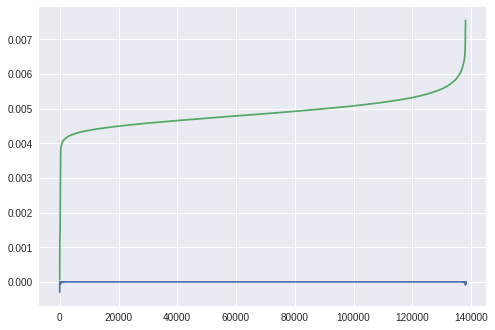

In [198]:
import matplotlib.pyplot as plt
distances = np.sort(dists[np.logical_not(dups)].flatten())
thresh_jump = distances[:-1] - distances[1:]
turn_point = np.argmax(thresh_jump[:-1]- thresh_jump[1:])
print(distances[turn_point])
plt.plot(thresh_jump)
plt.plot(distances)

In [0]:
# This achieved the highest score so far!
y_pred = insert_new_whale(y_pred_raw,dists,9.85486915e-04)

In [0]:
import pandas
# Now its time to create the submission file
def decode_label(label):
    if label == 0:
        return 'new_whale'
    # w_e15442c
    hex_str = hex(label)[2:]
    assert len(hex_str) <= 7
    hex_str = '0'*(7-len(hex_str)) + hex_str
    return 'w_{}'.format(hex_str)
  
def create_submission(img_paths,y_pred,target_path):
    assert len(img_paths) == len(y_pred)
    assert y_pred.shape[1] <= 5
    sep = ' '
    pred_strs = [sep.join([decode_label(label) for label in pred]) for pred in y_pred]
    frame = pandas.DataFrame({'Image': img_paths, 'Id': pred_strs})
    frame.to_csv(target_path,index=False)
    return frame

In [0]:
import os
from google.colab import files
import datetime
now_str = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")
create_submission(os.listdir('data/test'),y_pred, f'submission_{now_str}.csv')
# !gsutil cp submission.csv gs://ni-project-tu-mlengine/submission_29_6.csv
files.download(f'submission_{now_str}.csv')

In [163]:
with h5py.File('test_precomputed.h5', 'r') as f:
  X_test = np.array(f['X'])
  print(X_test[])

(31220, 1, 1, 2048)


In [86]:
!gsutil cp data/test_precomputed.h5 gs://ni-project-tu-mlengine

Copying file://data/test_precomputed.h5 [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/122.0 MiB.                                    


# Duplicate Detection



In [0]:
from os.path import join
# load train and test data
train_loader = ImageLoader(
    labels_csv=join(config.data_dir, "train.csv"),
    path=join(config.data_dir, "train"),
    batch_size=1,
    target_size=config.image_target_size,
    augment=False,
    return_labels=True,
    eliminate_new_whale=False,
    normalize=False,
    shuffle=False
)


test_loader = ImageLoader(
    path=join(config.data_dir, "test"),
    batch_size=100,
    target_size=config.image_target_size,
    augment=False,
    normalize=False
)

In [0]:
from tqdm import tqdm

def image_hash(img):
  mask = img > img.mean()
  return hex((np.nonzero(mask.flatten())[0]).sum())

class DuplicateCheatPredictor():
  
  def __init__(self):
    self.hash_to_label = dict()
    self.hash_to_filename = dict()
  
  def fit_generator(self,train_gen):
    img_paths = train_gen.img_paths
    for i in tqdm(range(len(train_gen)),desc='Fitting duplicate predictor'):
      x_batch, y_batch = train_gen[i]
      hashes = list(map(image_hash,x_batch))
      entries = dict(zip(hashes,y_batch))
      for hash in hashes:
        if hash in self.hash_to_filename:
          self.hash_to_filename[hash].append(i)
        else:
          self.hash_to_filename[hash] = [i]
      self.hash_to_label.update(entries)
    
  def predict_generator(self,gen):
    y_pred = []
    for i in tqdm(range(len(gen)),desc='Searching for duplicates...'):
      x_batch = gen[i]
      hashes = list(map(image_hash,x_batch))
      pred_fn = lambda h: self.hash_to_label[h] if h in self.hash_to_label else 0
      predictions = list(map(pred_fn,hashes))
      y_pred += predictions
    return np.array(y_pred)

In [0]:
predictor = DuplicateCheatPredictor()
predictor.fit_generator(train_loader)

In [68]:
duplicates = [l for l in predictor.hash_to_filename.values() if len(l) > 1]
duplicates

[[5, 9411],
 [7, 9249],
 [12, 4901],
 [20, 8956],
 [21, 905],
 [42, 2045],
 [45, 4892],
 [71, 76],
 [73, 8520],
 [81, 8455],
 [90, 8668],
 [103, 1042],
 [109, 435],
 [110, 8490],
 [114, 2112],
 [123, 7996],
 [127, 1622],
 [137, 5171],
 [141, 9150],
 [147, 9816],
 [150, 231],
 [155, 924],
 [163, 9137],
 [164, 2316],
 [171, 6366],
 [179, 9571],
 [185, 1441],
 [187, 8167],
 [188, 3434],
 [189, 9480],
 [191, 3012],
 [194, 3703],
 [215, 2996],
 [229, 9676],
 [250, 7282],
 [265, 8735],
 [274, 583],
 [275, 8784],
 [281, 5243],
 [301, 8826],
 [304, 3990],
 [308, 4254],
 [310, 2053],
 [328, 1827],
 [329, 4477],
 [354, 3396],
 [359, 2469],
 [360, 9283],
 [372, 3071],
 [390, 7110],
 [394, 4245],
 [400, 5166],
 [409, 7155],
 [424, 5070],
 [437, 1045],
 [438, 6796],
 [447, 2698],
 [453, 5181],
 [485, 9204],
 [489, 4906],
 [491, 1955],
 [492, 1715],
 [494, 8622],
 [498, 3806],
 [509, 3907],
 [514, 6980],
 [527, 5316],
 [540, 6614],
 [545, 7486],
 [548, 2938],
 [554, 6706],
 [561, 3010],
 [562, 6982]

In [0]:
import h5py
with h5py.File('data/train_precomputed.h5', 'a') as f:
  n_aug = 10
  y = f['y'][::n_aug+1]
  img_paths = train_loader.img_paths
  
  is_dup = np.zeros(len(y),dtype='bool')
  for dup in duplicates:
    for idx in dup[1:]:
      is_dup[idx] = True

  dup = np.arange(len(y))[is_dup] * (n_aug+1)
  dup = np.repeat(dup,n_aug + 1) + np.repeat(np.arange(n_aug + 1)[np.newaxis], len(dup), axis=0).flatten()
  f.create_dataset('duplicate_indices',data=dup)
  new_whales = np.arange(len(f['y']))[np.array(f['y']) == 0]
  f.create_dataset('new_whale_indices',data=new_whales)

In [38]:
img_paths

array(['00022e1a.jpg', '00022e1a.jpg', '00022e1a.jpg', ...,
       'fffd4260.jpg', 'fffd4260.jpg', 'fffd4260.jpg'], dtype=object)

In [27]:
y_pred_cheat = predictor.predict_generator(test_loader)

Searching for duplicates...: 100%|██████████| 157/157 [01:09<00:00,  2.25it/s]


In [23]:
print((y_pred_cheat == 0).sum())

798


In [197]:
print(y_pred.shape)
y_pred_final = np.hstack([y_pred_cheat[:,np.newaxis],y_pred[:,:4]])
create_submission(test_loader.img_paths,y_pred_final, 'submission5000.csv')
from google.colab import files

files.download('submission5000.csv')

(15610, 5)


# Presentation

In [0]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/train.csv')

In [19]:
counts = pd.DataFrame(df.groupby('Id').count().values,columns=['id','imgcount'])
counts.groupby('imgcount').count()

ValueError: ignored